# 第十 讲 使用神经网络进行客户流失预警 

In [2]:
from sklearn.neural_network import MLPClassifier
%matplotlib inline
import os
import numpy as np
from scipy import stats
import pandas as pd
import sklearn.cross_validation as cross_validation
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

#os.chdir('Q:/data')
pd.set_option('display.max_columns', None)

/home/quant/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
data = pd.read_csv('telecom_churn.csv')
data.head()

,subscriberID,churn,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10000
0,19164958,1,0,20,2,12,16,0,113.666667,-8.0,0,1,0,0,1,1,0,0,0,0
1,39244924,1,1,20,0,21,5,0,274.000000,-371.0,0,1,2,1,3,2,2,1,0,1
2,39578413,1,0,11,1,47,3,0,392.000000,-784.0,0,1,0,0,3,3,0,0,0,1
3,40992265,1,0,43,0,4,12,0,31.000000,-76.0,0,1,2,1,3,3,0,0,0,1
4,43061957,1,1,60,0,9,14,0,129.333333,-334.0,0,1,0,0,3,3,0,0,0,0


In [6]:
#随机抽样，建立训练集与测试集
train, test = cross_validation.train_test_split(data, test_size=1000)

In [36]:
from sklearn import preprocessing
#进行极差标准化
train_X = train.ix[:, 3:-1]
test_X = test.ix[:, 3:-1]
scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)
train_Y = train['churn'].get_values()  # 为满足后续(pybrain)建模需要做相应变换
test_Y = test['churn'].get_values()

http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [70]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(100), random_state=1)

clf.fit(train_X, train_Y) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [71]:
test_Y_pred=clf.predict(test_X)

## Index

In [72]:
pd.crosstab(test_Y, test_Y_pred)

col_0,0,1
row_0,,
0,450,94
1,85,371


In [73]:
from pybrain.tools.validation import Validator

Validator.classificationPerformance( test_Y_pred, test_Y )

0.821

In [74]:
import sklearn.metrics as metrics
print metrics.classification_report(test_Y, test_Y_pred)

             precision    recall  f1-score   support

          0       0.84      0.83      0.83       544
          1       0.80      0.81      0.81       456

avg / total       0.82      0.82      0.82      1000



## ROC Curve

In [75]:
test_est_p=clf.predict_proba(test_X)[:,1]
train_est_p=clf.predict_proba(train_X)[:,1]

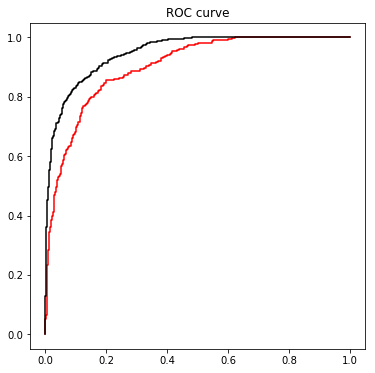

In [76]:
fpr_test, tpr_test, th_test = metrics.roc_curve(test_Y, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_Y, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test,color='red')
plt.plot(fpr_train, tpr_train,color='black')
plt.title('ROC curve')